README: updated: 
- applied cross validation when fitting first layer model

In [116]:
import os
os.chdir('/Users/liyuan/desktop/SI699/codes')
import pandas as pd
import numpy as np
import time

from ts_modeling_v2 import TsModeling
from reformat_data_by_day import Reformat_data
from time_feature_modeling import TimeFeatureModeling
from help import sample_data, get_rmse, get_predictions,extract_time_features

import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
# load all data
train = pd.read_csv('../expedia_data/train.csv')
test = pd.read_csv('../expedia_data/test.csv')
cols_train_only = [col for col in train.columns.unique().tolist() if col not in test.columns.unique().tolist()]
train = train.drop(columns = cols_train_only)
all_data = pd.concat([train, test], ignore_index=True)

In [3]:
print('there are %d records in train and test data combined' % len(all_data))

there are 16540159 records in train and test data combined


In [4]:
# get data by property_id
prop_id_lst = all_data['prop_id'].unique().tolist()
print('there are %d property id'%len(prop_id_lst))

# get data by property id
prop_data = all_data[all_data['prop_id'] == 116942]
print('property 116942 has %d records' % len(prop_data))

# get daily property data
tsm = TsModeling()
prop_data = tsm.process_data_by_prop(prop_data)
daily_price = prop_data[['price_usd']].resample('D').median()
print('property 116942 has %d records by day'% len(daily_price))

there are 140821 property id
property 116942 has 7383 records
property 116942 has 242 records by day


/Users/liyuan/Desktop/SI699/codes/ts_modeling_v2.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  prop_data['date_time'] = pd.to_datetime(prop_data.date_time)


In [10]:
def split_data_cv(data):
    '''get train, test set for cross validation '''
    training_size = int(len(data) * 0.8)   
    test_size = int(len(data) * 0.2)
    print('training size: %d'%training_size)
    print('test size: %d'%test_size)
    # split data by temporal order
    train_data = data.iloc[0: training_size]
    test_data = data.iloc[training_size:]
    return train_data, test_data

# train test split for cross validation
train_data, test_data = split_data_cv(daily_price)

training size: 193
test size: 48


In [91]:
test_data.head()

,price_usd
date_time,
2013-05-13,124.0
2013-05-14,153.0
2013-05-15,107.0
2013-05-16,115.0
2013-05-17,101.5


In [18]:
# updated: cross validation written by Crystal (04/13/2019)
def get_kf_list(X_train,y_train):
    ''' here test data actually refers to validation data'''
    X_train_kf = []
    y_train_kf = []
    X_test_kf = []
    y_test_kf = []
    kf = KFold(n_splits = 5)
    result = []
    for train, test in kf.split(X_train):
        result.append([train, test])
    n = 0
    for i in result:
        X_train_kf.append(X_train.iloc[result[n][0]])
        X_test_kf.append(X_train.iloc[result[n][1]])
        y_train_kf.append(y_train.iloc[result[n][0]])
        y_test_kf.append(y_train.iloc[result[n][1]])
        n =+ 1
    return X_train_kf, X_test_kf, y_train_kf, y_test_kf

In [20]:
X_train_kf, X_test_kf, y_train_kf, y_test_kf = get_kf_list(train_data,train_data)

In [117]:
def get_ts_list(X_train,y_train):
    X_train_ts = []
    X_test_ts = []
    y_train_ts = []
    y_test_ts = []
    
    # only two split can get non-overlapping records due to limited training data
    tscv = TimeSeriesSplit(n_splits=2)
    result_ts = []
    for train, test in tscv.split(X_train):
        result_ts.append([train, test])
    n = 0
    for i in result_ts:
        X_train_ts.append(X_train.iloc[result_ts[n][0]])
        X_test_ts.append(X_train.iloc[result_ts[n][1]])
        y_train_ts.append(y_train.iloc[result_ts[n][0]])
        y_test_ts.append(y_train.iloc[result_ts[n][1]])
        n =+ 1
    return X_train_ts, X_test_ts, y_train_ts, y_test_ts

In [118]:
X_train_ts, X_test_ts, y_train_ts, y_test_ts = get_ts_list(train_data,train_data)
# note: in ARIMA modeling, X_train_ts = y_train_ts

In [151]:
print(len(X_train_ts[0]))
print(len(X_test_ts[0]))

65
64


In [146]:
from statsmodels.tsa.arima_model import ARIMA
def get_model_performance_cv(train, val, p,d,q):
    '''[data] is source data what model is trying to predict on; 
        combined to use with fit_ARIMA_model '''
    history = [x for x in train]
    predictions = list()
    for t in range(len(val)):
        model = ARIMA(history, order=(p,d,q))  
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = data[t]
        history.append(obs)
    mse = mean_squared_error(data, predictions)
    rmse = np.sqrt(mse)
    print('RMSE: %.3f' % rmse)
    # plot
    pyplot.plot(val)
    pyplot.plot(predictions, color='red')
    pyplot.show()
    return predictions

def fit_ARIMA_model_cv(train,val, test, p,d,q):
    '''fit values and get predictions; data --> price data with date_time as index, format as a dataframe'''
    # get training (validation) predictions
    history = [x for x in train]
    ARIMA_val_predictions  = get_model_performance_cv(history,val,p,d,q)
    # get test predictions
    # concatenate train and val (np.array)
#     concat = np.concatenate((train, val), axis=0)  
#     history = [x for x in concat]
#     ARIMA_test_predictions = get_model_performance_cv(history,test,p,d,q)
#     return ARIMA_val_predictions, ARIMA_test_predictions
    return ARIMA_val_predictions


In [147]:
X_train_ts[0]
y_test_ts[0]
test_data.head()

,price_usd
date_time,
2013-05-13,124.0
2013-05-14,153.0
2013-05-15,107.0
2013-05-16,115.0
2013-05-17,101.5


In [159]:
test = test_data
# TODO: fit ARIMA model
for i in range(2):
    train = X_train_kf[i] # train data
    val = y_test_kf[i]  # val data
    # predictions = get_model_performance_cv(X_train_ts,y_test_ts,2,0,0)
    fit_ARIMA_model_cv(train,val,test, 2,0,0)

ValueError: Insufficient degrees of freedom to estimate

In [ ]:
val_predictions, test_predictions = tsm.fit_ARIMA_model(daily_price.dropna(), 2,0,0)

In [5]:
# TODO: set up cross validation code pipeline
# fit ARIMA
# tsm.get_auto_correlation(daily_price)
train, val, test = tsm.split_data_cv(daily_price) # split X

# print('plot for ARIMA model ...')
val_predictions, test_predictions = tsm.fit_ARIMA_model(daily_price.dropna(), 2,0,0)

training size: 155
validation size: 38
test size: 48


AttributeError: 'TsModeling' object has no attribute 'X_train'

In [ ]:
# fit ARIMA
tsm.get_auto_correlation(daily_price)
train, val, test = tsm.split_data(daily_price) # split X
print('plot for ARIMA model ...')
val_predictions, test_predictions = tsm.fit_ARIMA_model(daily_price.dropna(), 2,0,0)

   date_time  price_usd  day  week  month  quarter
0 2012-11-01    105.000    1    44     11        4
1 2012-11-02    105.000    2    44     11        4
2 2012-11-03    127.140    3    44     11        4
3 2012-11-04     91.380    4    44     11        4
4 2012-11-05     91.605    5    45     11        4
price data len: 242
242
variance of data: 357

/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['day'] = price_data['date_time'].apply(lambda x: x.day)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  price_data['week'] = price_data['date_time'].apply(lambda x: x.week)
/Users/liyuan/Desktop/SI699/codes/time_feature_modeling.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe


training size: 155
validation size: 38
test size: 48
training RMSE: 16.352462388808384
valiation RMSE: 22.87300786282893
test RMSE: 20.36747232790119


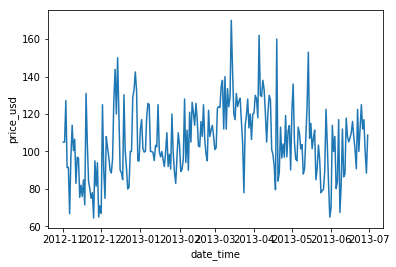

In [85]:
# fit regression model on daily_price
daily_price = extract_time_features(daily_price)
print(daily_price.head())
regression_y_pred_train, regression_y_pred_val, regression_y_pred_test = tsm.fit_regression_model(daily_price.dropna())
# print(regression_y_pred_train, regression_y_pred_val, regression_y_pred_test)

In [86]:
# task: second-layer modeling (XGBoost)
# has finished basic parameter tuning
model = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 5, reg_alpha = 20, n_estimators = 25) 
y_pred_train, y_pred_test = tsm.second_layer_modeling(model)

(38, 1)
(49, 1)
(38, 1)
(49, 1)
y_train shape: (38, 1)
y_test shape: (49, 1)
train rmse: 18
test rmse: 17


In [87]:
# checking
print(y_pred_train.shape)
print(y_pred_test.shape)

(38,)
(49,)


In [88]:
from sklearn.metrics import mean_squared_error
import numpy as np

def get_rmse(pred, true):
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    return rmse

In [89]:
# task: combine property modeling + time modeling
# get prediction results from Crystal's codes
y_pred_train_prop = pd.read_csv('../res/ElasticNet_y_pred_val.csv').values.ravel()
y_pred_test_prop = pd.read_csv('../res/ElasticNet_y_pred_test.csv').values.ravel()

# reshape predictions from time modeling
y_pred_train_ = y_pred_train.reshape(-1,1)
y_pred_test_ = y_pred_test.reshape(-1,1)

# reshape predictions from propery modeling
print(y_pred_train_prop.shape)
print(y_pred_test_prop.shape)
y_pred_train_prop_ = y_pred_train_prop.reshape(-1,1)
y_pred_test_prop_ = y_pred_test_prop.reshape(-1,1)

# combine predictions results with my codes
X_train = np.concatenate(( y_pred_train_prop_, y_pred_train_), axis=1)
X_test = np.concatenate(( y_pred_test_prop_, y_pred_test_), axis=1)
# get y_train, y_test
y_train = tsm.val
y_test = tsm.test

(38,)
(49,)


In [96]:
# task: fit third-layer model
# model = LinearRegression()
# model = xgb.XGBRegressor(learning_rate = 0.1, max_depth = 5, reg_alpha = 20, n_estimators = 20) 
model = RandomForestRegressor()

reg = model.fit(X_train, y_train)
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)
# get rmse
train_RMSE = get_rmse(y_pred_train ,y_train)
test_RMSE = get_rmse(y_pred_test ,y_test)
print('train rmse: %d'%train_RMSE)
print('test rmse: %d'%test_RMSE)

train rmse: 5
test rmse: 22


/anaconda3/envs/leetcode/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
